In [1]:
%load_ext autoreload
%autoreload 1

In [9]:
import sys 
sys.path.append("../..") 
%aimport p2v

In [13]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 20)

from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt

import mpltern

In [12]:
model = p2v.P2V()

2024-10-05 14:48:16 -- start loading Mag_venue_info_df
2024-10-05 14:48:16 -- finish.
2024-10-05 14:48:16 -- start loading labeled_journal_info_df
2024-10-05 14:48:16 -- finish.


In [18]:
def make_ternary_df(start_year, end_year):
    model.load_wv(start_year, end_year, 100, 10)
    VIDs = model.wv.index_to_key
    vectors = model.wv.get_normed_vectors()
    
    ternary_df = pd.DataFrame(list(zip(VIDs, vectors)), columns =['VID', 'vector'])
    VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
    ternary_df = ternary_df.loc[ternary_df.VID.isin(VID_labeled['VID'])]
    ternary_df['label'] = VID_labeled['label']
    
    ternary_df.loc[:,'venue_name'] = ternary_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])

    ternary_df.loc[ternary_df.label.isin(['Agricultural and Biological Sciences', 
                                          'Biochemistry, Genetics and Molecular Biology', 
                                          'Immunology and Microbiology', 
                                          'Neuroscience', 
                                          'Pharmacology, Toxicology and Pharmaceutics']), 'area'] = 'Life Science'
    ternary_df.loc[ternary_df.label.isin(['Medicine', 
                                          'Nursing',
                                          'Veterinary',
                                          'Dentistry',
                                          'Health Professions']), 'area'] = 'Health Science'
    ternary_df.loc[ternary_df.label.isin(['Chemical Engineering',
                                          'Chemistry',
                                          'Computer Science',
                                          'Earth and Planetary Sciences',
                                          'Energy',
                                          'Engineering',
                                          'Environmental Science',
                                          'Materials Science',
                                          'Mathematics',
                                          'Physics and Astronomy']), 'area'] = 'Physical Science'
    ternary_df.loc[ternary_df.label.isin(['Arts and Humanities',
                                          'Business, Management and Accounting',
                                          'Decision Sciences',
                                          'Economics, Econometrics and Finance',
                                          'Psychology',
                                          'Social Sciences']), 'area'] = 'Social Science'
    ternary_df.loc[ternary_df.label=='Multidisciplinary', 'area'] = 'Multidisciplinary'
    
    # add 5 artificial area average vectors
    pole_life = ternary_df[ternary_df.area == 'Life Science'].vector.mean()
    pole_health = ternary_df[ternary_df.area == 'Health Science'].vector.mean()
    pole_physical = ternary_df[ternary_df.area == 'Physical Science'].vector.mean()

    new_rows = pd.DataFrame([
        ['life_avg', pole_life, 'Pole', 'Life_AVG', 'Pole'],
        ['health_avg', pole_health, 'Pole', 'Health_AVG', 'Pole'],
        ['physical_avg', pole_physical, 'Pole', 'Physical_AVG', 'Pole'],
        ['multi_avg', ternary_df[ternary_df.area == 'Multidisciplinary'].vector.mean(), 'Pole', 'Multi_AVG', 'Pole'],
        ['social_avg', ternary_df[ternary_df.area == 'Social Science'].vector.mean(), 'Pole', 'Social_AVG', 'Pole']
        ], 
        columns=['VID', 'vector', 'label', 'venue_name', 'area'])
    ternary_df = pd.concat([ternary_df, new_rows], ignore_index=True)
    
    ternary_df['life_cs'] = ternary_df.vector.apply(lambda x: 
                                                    cosine_similarity(x.reshape(1, -1), pole_life.reshape(1, -1))[0][0])
    ternary_df['health_cs'] = ternary_df.vector.apply(lambda x: 
                                                      cosine_similarity(x.reshape(1, -1), pole_health.reshape(1, -1))[0][0])
    ternary_df['physical_cs'] = ternary_df.vector.apply(lambda x: 
                                                        cosine_similarity(x.reshape(1, -1), pole_physical.reshape(1, -1))[0][0])

    ternary_df[['life_cs', 'health_cs', 'physical_cs']] = ternary_df[['life_cs', 'health_cs', 'physical_cs']].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    ternary_df['cs_sum'] = ternary_df[['life_cs', 'health_cs', 'physical_cs']].sum(axis=1)
    ternary_df['life_cs'] = ternary_df['life_cs'] / ternary_df['cs_sum']
    ternary_df['health_cs'] = ternary_df['health_cs'] / ternary_df['cs_sum']
    ternary_df['physical_cs'] = ternary_df['physical_cs'] / ternary_df['cs_sum']
    ternary_df.drop(columns=['vector', 'cs_sum'], inplace=True)
    
    return ternary_df

# Plot parameters

In [4]:
life_color = '#0099FF'
health_color = '#CC00FF'
physical_color = '#FC9320'
social_color = '#16A90F'
multi_color = '#000000'

area_color_dict = {'Life Science': '#0099FF',
                   'Health Science': '#CC00FF',
                   'Physical Science': '#FC9320',
                   'Social Science': '#16A90F',
                   'Multidisciplinary': '#000000'}

# Generate 7 ternary_df
Store 7 `ternary_df` into `ternary_df_list.pkl`

In [60]:
ternary_df_list = []
for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    ternary_df = make_ternary_df(start_year, end_year)
    ternary_df_list.append(ternary_df)

2024-10-05 17:01:47 -- start loading word vectors...
2024-10-05 17:01:47 -- word vectors loaded, and its shape is: (1645, 100)
2024-10-05 17:01:47 -- start loading VID_labeled...
2024-10-05 17:01:47 -- finish.


2024-10-05 17:01:48 -- start loading word vectors...
2024-10-05 17:01:48 -- word vectors loaded, and its shape is: (3116, 100)
2024-10-05 17:01:48 -- start loading VID_labeled...
2024-10-05 17:01:48 -- finish.
2024-10-05 17:01:50 -- start loading word vectors...
2024-10-05 17:01:50 -- word vectors loaded, and its shape is: (5686, 100)
2024-10-05 17:01:50 -- start loading VID_labeled...
2024-10-05 17:01:50 -- finish.
2024-10-05 17:01:52 -- start loading word vectors...
2024-10-05 17:01:52 -- word vectors loaded, and its shape is: (9337, 100)
2024-10-05 17:01:52 -- start loading VID_labeled...
2024-10-05 17:01:52 -- finish.
2024-10-05 17:01:56 -- start loading word vectors...
2024-10-05 17:01:56 -- word vectors loaded, and its shape is: (15019, 100)
2024-10-05 17:01:56 -- start loading VID_labeled...
2024-10-05 17:01:56 -- finish.
2024-10-05 17:02:02 -- start loading word vectors...
2024-10-05 17:02:02 -- word vectors loaded, and its shape is: (27460, 100)
2024-10-05 17:02:02 -- start lo

In [61]:
import pickle

with open('ternary_df_list.pkl', 'wb') as f:
    pickle.dump(ternary_df_list, f)

# Plot scatters for 7 decades

In [62]:
import pickle

ternary_df_list = pickle.load(open('ternary_df_list.pkl', 'rb'))
ternary_df_list[0]

VID                                         label  \
0      137773608.0                             Multidisciplinary   
1      140251998.0  Biochemistry, Genetics and Molecular Biology   
2      111155417.0  Biochemistry, Genetics and Molecular Biology   
3       54862371.0                         Physics and Astronomy   
4        3880285.0                             Multidisciplinary   
...            ...                                           ...   
1253      life_avg                                          Pole   
1254    health_avg                                          Pole   
1255  physical_avg                                          Pole   
1256     multi_avg                                          Pole   
1257    social_avg                                          Pole   

                                    venue_name               area   life_cs  \
0                                       Nature  Multidisciplinary  0.475300   
1              Journal of Biological Chemistry       Life Science  0.435674   
2     Journal of the American Chemical Society       Life Science  0.350457   
3                              Physical Review   Physical Science  0.203328   
4                                      Science  Multidisciplinary  0.466711   
...                                        ...                ...       ...   
1253                                  Life_AVG               Pole  0.448206   
1254                                Health_AVG               Pole  0.297157   
1255                              Physical_AVG               Pole  0.285027   
1256                                 Multi_AVG               Pole  0.451343   
1257                                Social_AVG               Pole  0.266324   

      health_cs  physical_cs  
0      0.194530     0.330170  
1      0.369662     0.194664  
2      0.277572     0.371970  
3      0.173030     0.623641  
4      0.333373     0.199916  
...         ...          ...  
1253   0.283087     0.268707  
1254   0.475991     0.226852  
1255   0.228241     0.486732  
1256   0.227130     0.321527  
1257   0.314408     0.419267  

[1258 rows x 7 columns]

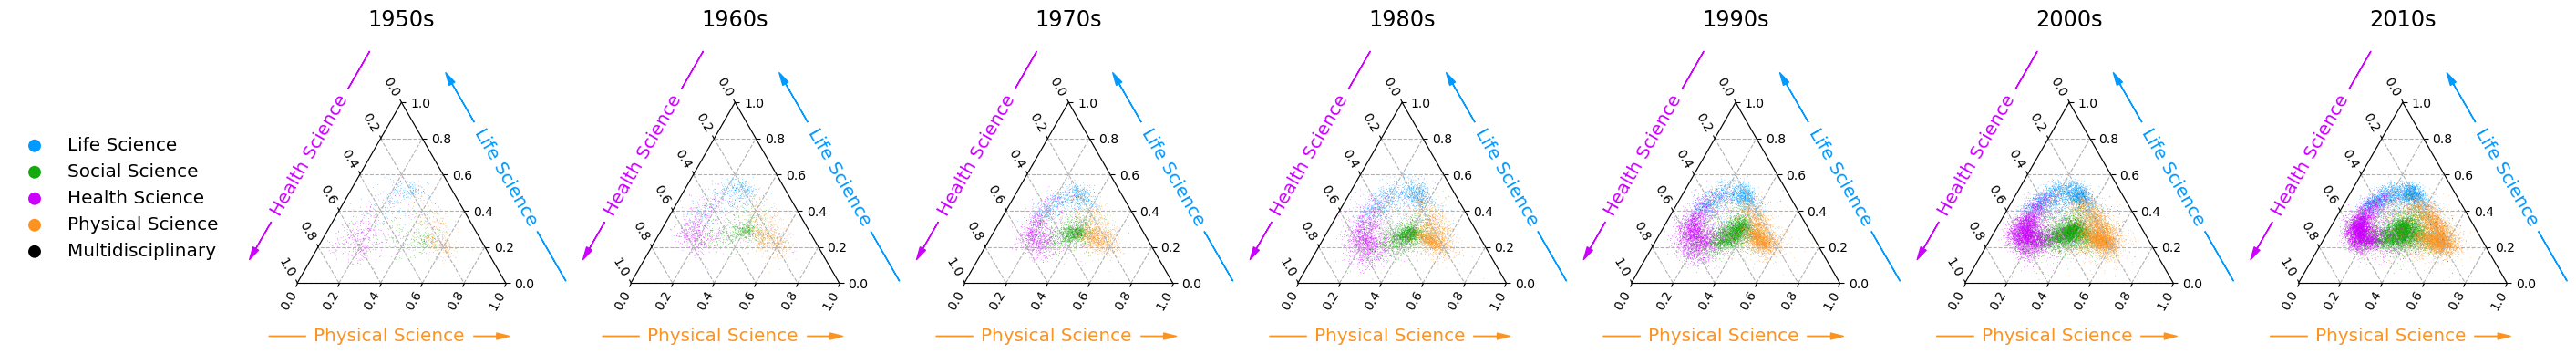

In [63]:
fig1 = plt.figure(figsize=(36, 9))
fig1.subplots_adjust(wspace=0.6)

# Start of arrows in barycentric coordinates.
ta = np.array([ 0.0, -0.25,  1.1])
la = np.array([ 1.1,  0.0, -0.25])
ra = np.array([-0.25,  1.1,  0.0])

# End of arrows in barycentric coordinates.
tb = np.array([ 1.0, -0.25,  0.1])
lb = np.array([ 0.1,  1.0, -0.25])
rb = np.array([-0.25,  0.1,  1.0])

tpos = (ta + tb) * 0.5
lpos = (la + lb) * 0.5
rpos = (ra + rb) * 0.5

for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
    ax = fig1.add_subplot(1, 8, i -13, projection='ternary')
    
    kwargs_label = {
        'transform': ax.transTernaryAxes,
        'backgroundcolor': 'w',
        'ha': 'center',
        'va': 'center',
        'rotation_mode': 'anchor',
        'zorder': -9,  # A bit higher on arrows, but still lower than others.
        'fontsize': 'x-large'
    }
    
    f = ax.transAxesProjection.transform

    kwargs_arrow = {
    'transform': ax.transAxes,  # Used with ``ax.transAxesProjection``
    'arrowstyle': arrowstyle,
    'linewidth': 1,
    'clip_on': False,  # To plot arrows outside triangle
    'zorder': -10,  # Very low value not to hide e.g. tick labels.
    }

    tarrow = FancyArrowPatch(f(ta), f(tb), ec=life_color, fc=life_color, **kwargs_arrow)
    larrow = FancyArrowPatch(f(la), f(lb), ec=health_color, fc=health_color, **kwargs_arrow)
    rarrow = FancyArrowPatch(f(ra), f(rb), ec=physical_color, fc=physical_color, **kwargs_arrow)
    
    ax.add_patch(tarrow)
    ax.add_patch(larrow)
    ax.add_patch(rarrow)

    ax.text(*tpos, 'Life Science'  , color=life_color, rotation=-60, **kwargs_label)
    ax.text(*lpos, 'Health Science' , color=health_color, rotation=60, **kwargs_label)
    ax.text(*rpos, 'Physical Science', color=physical_color, rotation=0, **kwargs_label)
    
    ax.grid(linestyle='--')

    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    ternary_df = ternary_df_list[i-15]

    for area in ['Life Science', 'Social Science', 'Health Science', 'Physical Science', 'Multidisciplinary']:
        tar_df = ternary_df[ternary_df.area == area]
        t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
        ax.scatter(t, l, r, label=area, marker='.', s=1, color=area_color_dict[area], edgecolors='none', alpha=1)

    ax.set_title(start_year+'s', pad=60, fontsize='xx-large')
ax.legend(markerscale=20, fontsize='x-large', edgecolor='white', bbox_to_anchor=(-10.5, 0.30, 0.6, 0.6))
plt.show()

In [29]:
fig1.savefig('7_decades_ternary_plot.pdf',
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# Clustering

In [64]:
import pickle

ternary_df_list = pickle.load(open('ternary_df_list.pkl', 'rb'))
ternary_df_list[0]

VID                                         label  \
0      137773608.0                             Multidisciplinary   
1      140251998.0  Biochemistry, Genetics and Molecular Biology   
2      111155417.0  Biochemistry, Genetics and Molecular Biology   
3       54862371.0                         Physics and Astronomy   
4        3880285.0                             Multidisciplinary   
...            ...                                           ...   
1253      life_avg                                          Pole   
1254    health_avg                                          Pole   
1255  physical_avg                                          Pole   
1256     multi_avg                                          Pole   
1257    social_avg                                          Pole   

                                    venue_name               area   life_cs  \
0                                       Nature  Multidisciplinary  0.475300   
1              Journal of Biological Chemistry       Life Science  0.435674   
2     Journal of the American Chemical Society       Life Science  0.350457   
3                              Physical Review   Physical Science  0.203328   
4                                      Science  Multidisciplinary  0.466711   
...                                        ...                ...       ...   
1253                                  Life_AVG               Pole  0.448206   
1254                                Health_AVG               Pole  0.297157   
1255                              Physical_AVG               Pole  0.285027   
1256                                 Multi_AVG               Pole  0.451343   
1257                                Social_AVG               Pole  0.266324   

      health_cs  physical_cs  
0      0.194530     0.330170  
1      0.369662     0.194664  
2      0.277572     0.371970  
3      0.173030     0.623641  
4      0.333373     0.199916  
...         ...          ...  
1253   0.283087     0.268707  
1254   0.475991     0.226852  
1255   0.228241     0.486732  
1256   0.227130     0.321527  
1257   0.314408     0.419267  

[1258 rows x 7 columns]

In [65]:
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN

for ternary_df in ternary_df_list:
    features = ternary_df[['life_cs', 'health_cs', 'physical_cs']]

    # among different clustering algorithms, KMeans is the most stable one
    kmeans = KMeans(n_clusters=4, random_state=42)
    ternary_df['cluster'] = kmeans.fit_predict(features)

    # hdbscan = HDBSCAN(min_cluster_size=10, min_samples=5)
    # ternary_df['cluster'] = hdbscan.fit_predict(features)

    # dbscan = DBSCAN(eps=0.5)
    # ternary_df['cluster'] = dbscan.fit_predict(features)

    # 1. count the number of each label in each cluster
    cluster_label_counts = ternary_df.groupby('cluster')['area'].value_counts()
    # 2. create a dictionary that maps cluster to the label with the most counts
    cluster_to_label = cluster_label_counts.groupby(level=0).idxmax().apply(lambda x: x[1]).to_dict()
    # 3. rename the cluster according to the dictionary
    ternary_df['cluster_label'] = ternary_df['cluster'].map(cluster_to_label)
    # 4. create a new column to label whether cluster_label and area are the same
    ternary_df['label_area_match'] = ternary_df['cluster_label'] == ternary_df['area']

c:\Users\lyuzhuoqi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\lyuzhuoqi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


In [66]:
from clusim.clustering import Clustering
import clusim.sim as sim

for ternary_df in ternary_df_list:
    # Key: row index, val: value of 'area' column
    dict_original = {index: [row['area']] for index, row in ternary_df.iterrows()}
    # Key: row index, val: value of 'cluster_label' column
    dict_clustering = {index: [row['cluster_label']] for index, row in ternary_df.iterrows()}

    c_original = Clustering(elm2clu_dict = dict_original)
    c_clustering = Clustering(elm2clu_dict = dict_clustering)

    elementScores, relabeled_elements = sim.element_sim_elscore(c_original, c_clustering, alpha = 0.9)
    ternary_df['sim_score'] = elementScores

In [67]:
import pickle

# store the ternary_df_list, write clustering results to file
with open('ternary_df_list.pkl', 'wb') as f:
    pickle.dump(ternary_df_list, f)

# Load `ternary_df_list.pkl`

In [2]:
import pickle

ternary_df_list = pickle.load(open('ternary_df_list.pkl', 'rb'))
ternary_df_list[0]

VID                                         label  \
0      137773608.0                             Multidisciplinary   
1      140251998.0  Biochemistry, Genetics and Molecular Biology   
2      111155417.0  Biochemistry, Genetics and Molecular Biology   
3       54862371.0                         Physics and Astronomy   
4        3880285.0                             Multidisciplinary   
...            ...                                           ...   
1253      life_avg                                          Pole   
1254    health_avg                                          Pole   
1255  physical_avg                                          Pole   
1256     multi_avg                                          Pole   
1257    social_avg                                          Pole   

                                    venue_name               area   life_cs  \
0                                       Nature  Multidisciplinary  0.475300   
1              Journal of Biological Chemistry       Life Science  0.435674   
2     Journal of the American Chemical Society       Life Science  0.350457   
3                              Physical Review   Physical Science  0.203328   
4                                      Science  Multidisciplinary  0.466711   
...                                        ...                ...       ...   
1253                                  Life_AVG               Pole  0.448206   
1254                                Health_AVG               Pole  0.297157   
1255                              Physical_AVG               Pole  0.285027   
1256                                 Multi_AVG               Pole  0.451343   
1257                                Social_AVG               Pole  0.266324   

      health_cs  physical_cs  cluster     cluster_label  label_area_match  \
0      0.194530     0.330170        1      Life Science             False   
1      0.369662     0.194664        0    Health Science             False   
2      0.277572     0.371970        1      Life Science              True   
3      0.173030     0.623641        3  Physical Science              True   
4      0.333373     0.199916        1      Life Science             False   
...         ...          ...      ...               ...               ...   
1253   0.283087     0.268707        1      Life Science             False   
1254   0.475991     0.226852        0    Health Science             False   
1255   0.228241     0.486732        3  Physical Science             False   
1256   0.227130     0.321527        1      Life Science             False   
1257   0.314408     0.419267        3  Physical Science             False   

      sim_score  
0      0.022901  
1      0.118609  
2      0.725191  
3      0.585799  
4      0.022901  
...         ...  
1253   0.007634  
1254   0.002045  
1255   0.003945  
1256   0.007634  
1257   0.003945  

[1258 rows x 11 columns]

# Statiscs

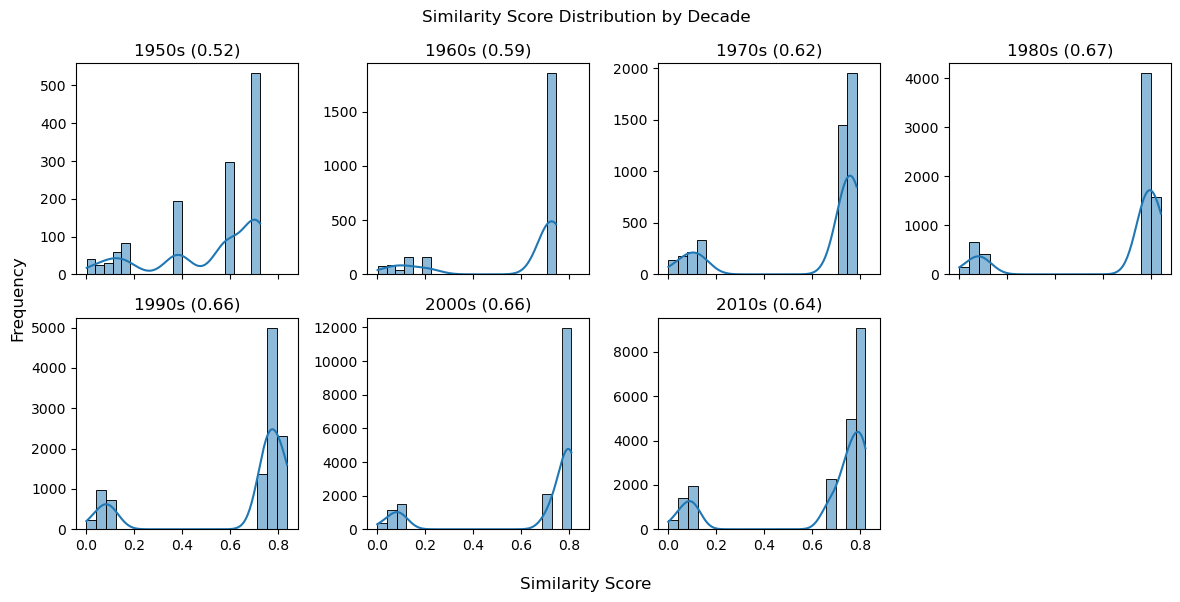

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# 定义年代标签
decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

# 创建一个2行4列的子图布局 (留出空间)
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True)
axes = axes.flatten()

# 绘制每个DataFrame中sim_score列的分布
for i, df in enumerate(ternary_df_list):
    # 计算平均sim_score
    mean_sim_score = df['sim_score'].mean()
    mean_sim_score_str = f"({mean_sim_score:.2f})"  # 格式化为小数点后两位

    sns.histplot(df['sim_score'], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"{decades[i]} {mean_sim_score_str}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
fig.supylabel('Frequency')  # 设置y轴标签
fig.supxlabel('Similarity Score')  # 设置x轴标签
fig.suptitle('Similarity Score Distribution by Decade')  # 设置总标题
# 删除最后一个空白子图（因为有2x4布局，但只有7个年代）
fig.delaxes(axes[-1])

# 调整布局使图形显示更紧凑
plt.tight_layout()
plt.show()

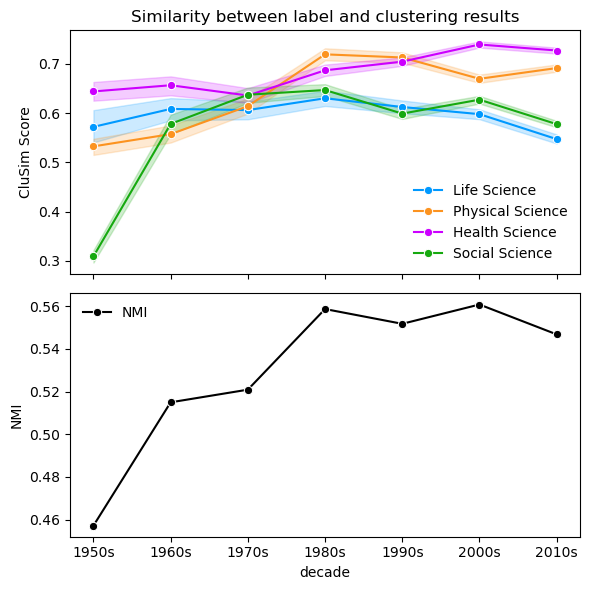

In [70]:
from sklearn.metrics import normalized_mutual_info_score

# 用于保存每个cluster的平均值
avg_match_list = []
NMI_list = []
decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

# 创建一个空的 DataFrame 来存储所有数据
combined_df = pd.DataFrame()
for i, ternary_df in enumerate(ternary_df_list):
    # drop rows with area eqaul to 'Pole' or 'Multidisciplinary'
    ternary_df_filtered = ternary_df.copy()[(ternary_df['area'] != 'Pole') & (ternary_df['area'] != 'Multidisciplinary')]

    nmi_score = normalized_mutual_info_score(ternary_df_filtered['area'], ternary_df_filtered['cluster_label'])
    NMI_list.append(nmi_score)

    ternary_df_filtered.loc[:,'decade'] = decades[i]  # 添加对应年代
    combined_df = pd.concat([combined_df, ternary_df_filtered])  # 将当前df追加到combined_df中
NMI_df = pd.DataFrame({'decade': decades, 'NMI': NMI_list})

fig2 = plt.figure(figsize=(6,6))
ax1 = fig2.add_subplot(2, 1, 1)
sns.lineplot(data=combined_df,
             x='decade',
             y='sim_score',
             hue='area',
             palette=area_color_dict,
             errorbar='ci',
             marker='o',
             ax=ax1)
ax1.set_title('Similarity between label and clustering results')
ax1.set_xlabel('')
ax1.set_xticklabels([])
ax1.set_ylabel('CluSim Score')
ax1.legend(frameon=False)

ax2 = fig2.add_subplot(2, 1, 2)
sns.lineplot(data=NMI_df, x='decade', y='NMI', marker='o', color='black', label='NMI', ax=ax2)
ax2.set_ylabel('NMI')
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()


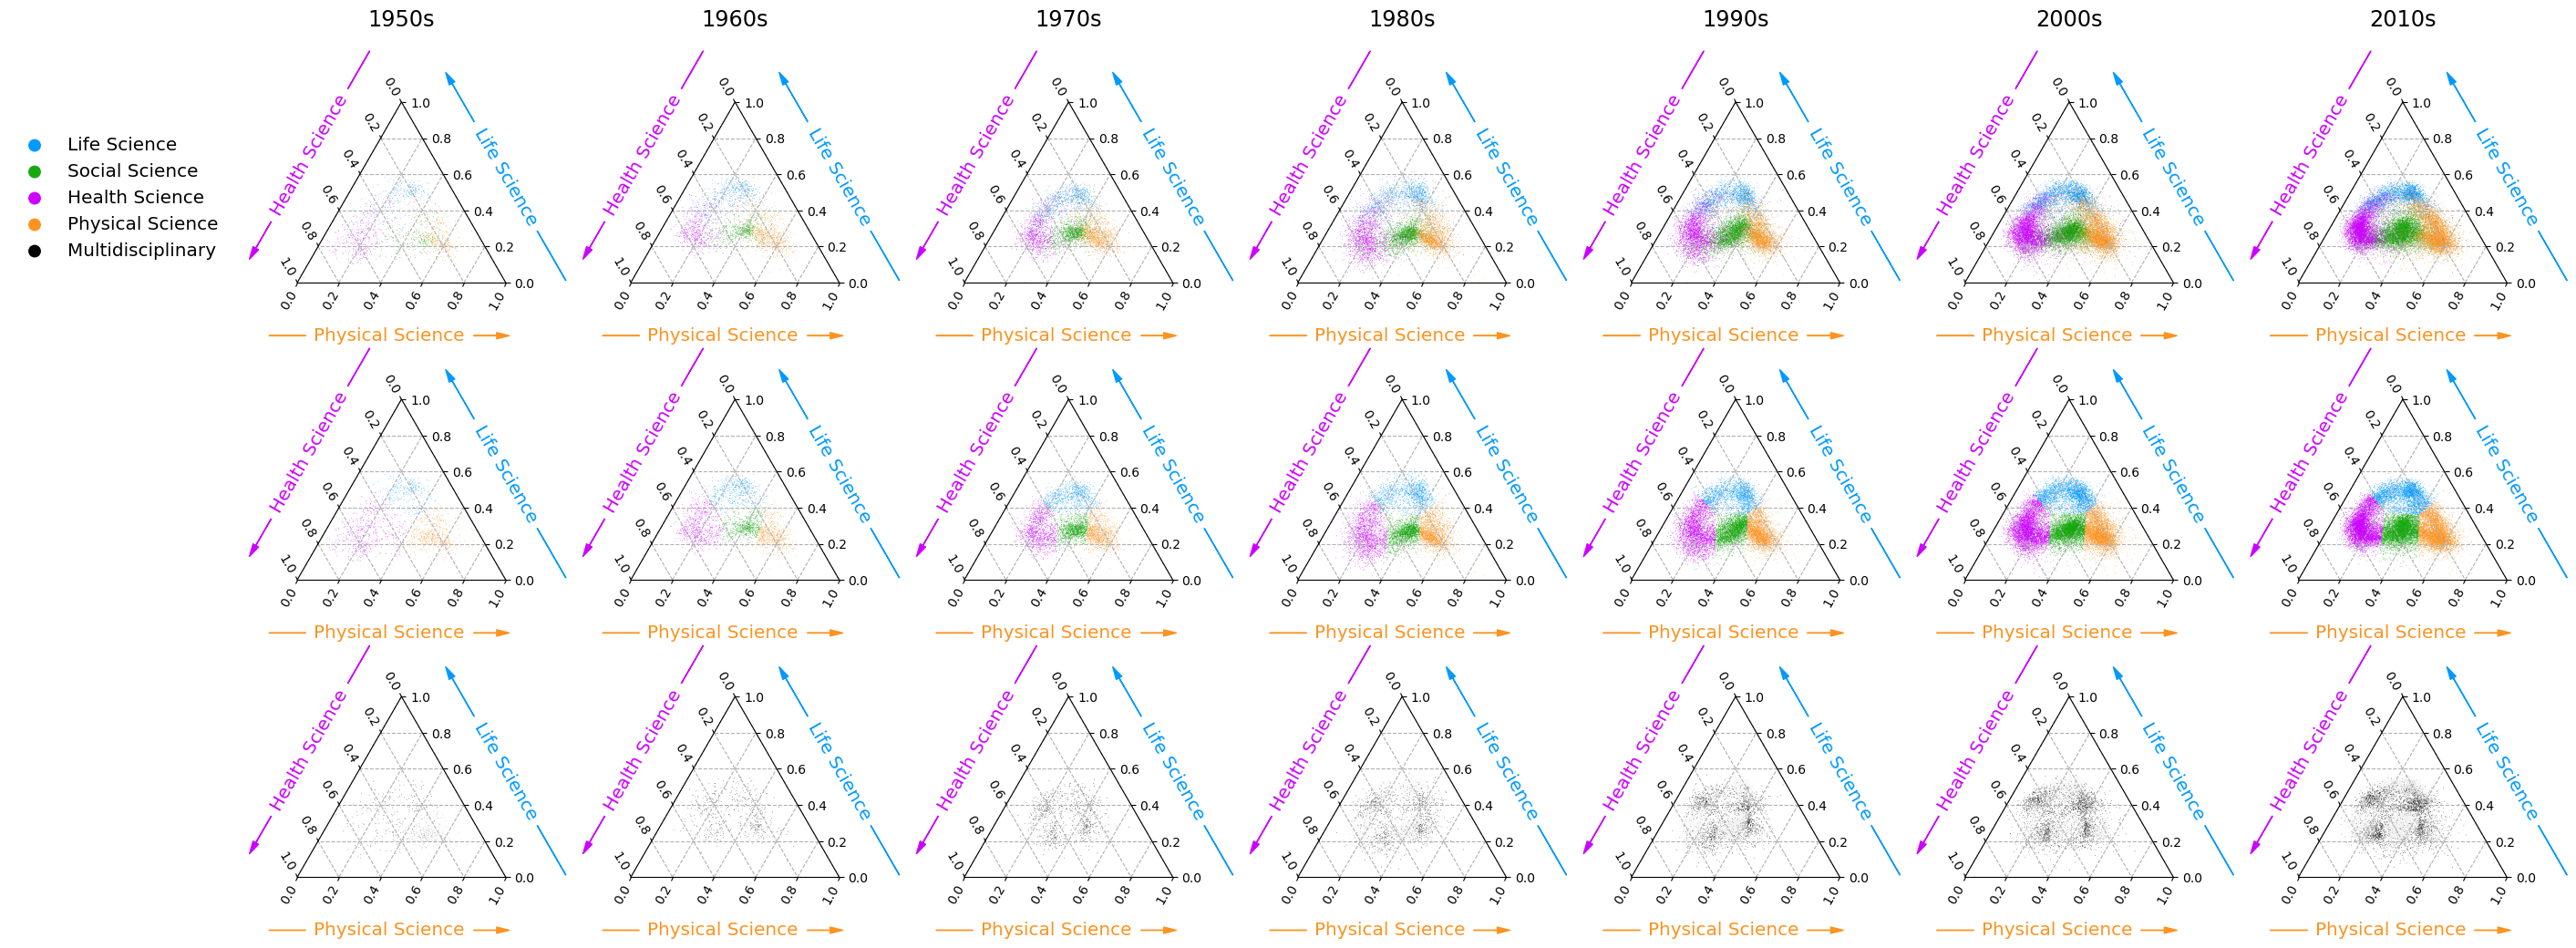

In [71]:
fig3 = plt.figure(figsize=(36, 12))
fig3.subplots_adjust(wspace=0.6)

# Start of arrows in barycentric coordinates.
ta = np.array([ 0.0, -0.25,  1.1])
la = np.array([ 1.1,  0.0, -0.25])
ra = np.array([-0.25,  1.1,  0.0])

# End of arrows in barycentric coordinates.
tb = np.array([ 1.0, -0.25,  0.1])
lb = np.array([ 0.1,  1.0, -0.25])
rb = np.array([-0.25,  0.1,  1.0])

tpos = (ta + tb) * 0.5
lpos = (la + lb) * 0.5
rpos = (ra + rb) * 0.5

start_year_list = [str(year) for year in range(1950, 2020, 10)]
for i, ternary_df in enumerate(ternary_df_list):
    ax_up = fig3.add_subplot(3, 8, i+1, projection='ternary')
    ax_mid = fig3.add_subplot(3, 8, i+9, projection='ternary')
    ax_low = fig3.add_subplot(3, 8, i+17, projection='ternary')

    for ax in [ax_up, ax_mid, ax_low]:
        start_year = start_year_list[i]
        
        kwargs_label = {
            'transform': ax.transTernaryAxes,
            'backgroundcolor': 'w',
            'ha': 'center',
            'va': 'center',
            'rotation_mode': 'anchor',
            'zorder': -9,  # A bit higher on arrows, but still lower than others.
            'fontsize': 'x-large'
        }
        
        f = ax.transAxesProjection.transform

        kwargs_arrow = {
        'transform': ax.transAxes,  # Used with ``ax.transAxesProjection``
        'arrowstyle': arrowstyle,
        'linewidth': 1,
        'clip_on': False,  # To plot arrows outside triangle
        'zorder': -10,  # Very low value not to hide e.g. tick labels.
        }

        tarrow = FancyArrowPatch(f(ta), f(tb), ec=life_color, fc=life_color, **kwargs_arrow)
        larrow = FancyArrowPatch(f(la), f(lb), ec=health_color, fc=health_color, **kwargs_arrow)
        rarrow = FancyArrowPatch(f(ra), f(rb), ec=physical_color, fc=physical_color, **kwargs_arrow)
        
        ax.add_patch(tarrow)
        ax.add_patch(larrow)
        ax.add_patch(rarrow)
        
        ax.text(*tpos, 'Life Science'  , color=life_color, rotation=-60, **kwargs_label)
        ax.text(*lpos, 'Health Science' , color=health_color, rotation=60, **kwargs_label)
        ax.text(*rpos, 'Physical Science', color=physical_color, rotation=0, **kwargs_label)
        
        ax.grid(linestyle='--')

    # plot the actual scatters in the top axis
    for area in ['Life Science', 'Social Science', 'Health Science', 'Physical Science', 'Multidisciplinary']:
        tar_df = ternary_df[ternary_df.area == area]
        t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
        ax_up.scatter(t, l, r, label=area, marker='.', s=1, color=area_color_dict[area], edgecolors='none', alpha=1)
    ax_up.set_title(start_year+'s', pad=60, fontsize='xx-large')
    # plot the clustering resutls in the middle axis
    for cluster_label in ['Life Science', 'Social Science', 'Health Science', 'Physical Science']:
        tar_df = ternary_df[ternary_df.cluster_label == cluster_label]
        t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
        ax_mid.scatter(t, l, r, label=cluster_label, marker='.', s=1, color=area_color_dict[cluster_label], edgecolors='none', alpha=1)
    # plot the CluSim scores in the bottom axis
    t, l, r = ternary_df.life_cs, ternary_df.health_cs, ternary_df.physical_cs
    ax_low.scatter(t, l, r, marker='.', s=1, c=[-x for x in ternary_df['sim_score']], cmap='Greys', edgecolors='none', alpha=1)

ax_up.legend(markerscale=20, fontsize='x-large', edgecolor='white', bbox_to_anchor=(-10.5, 0.30, 0.6, 0.6))

plt.show()

# distribution of periodicals' similarity to three corner vectors

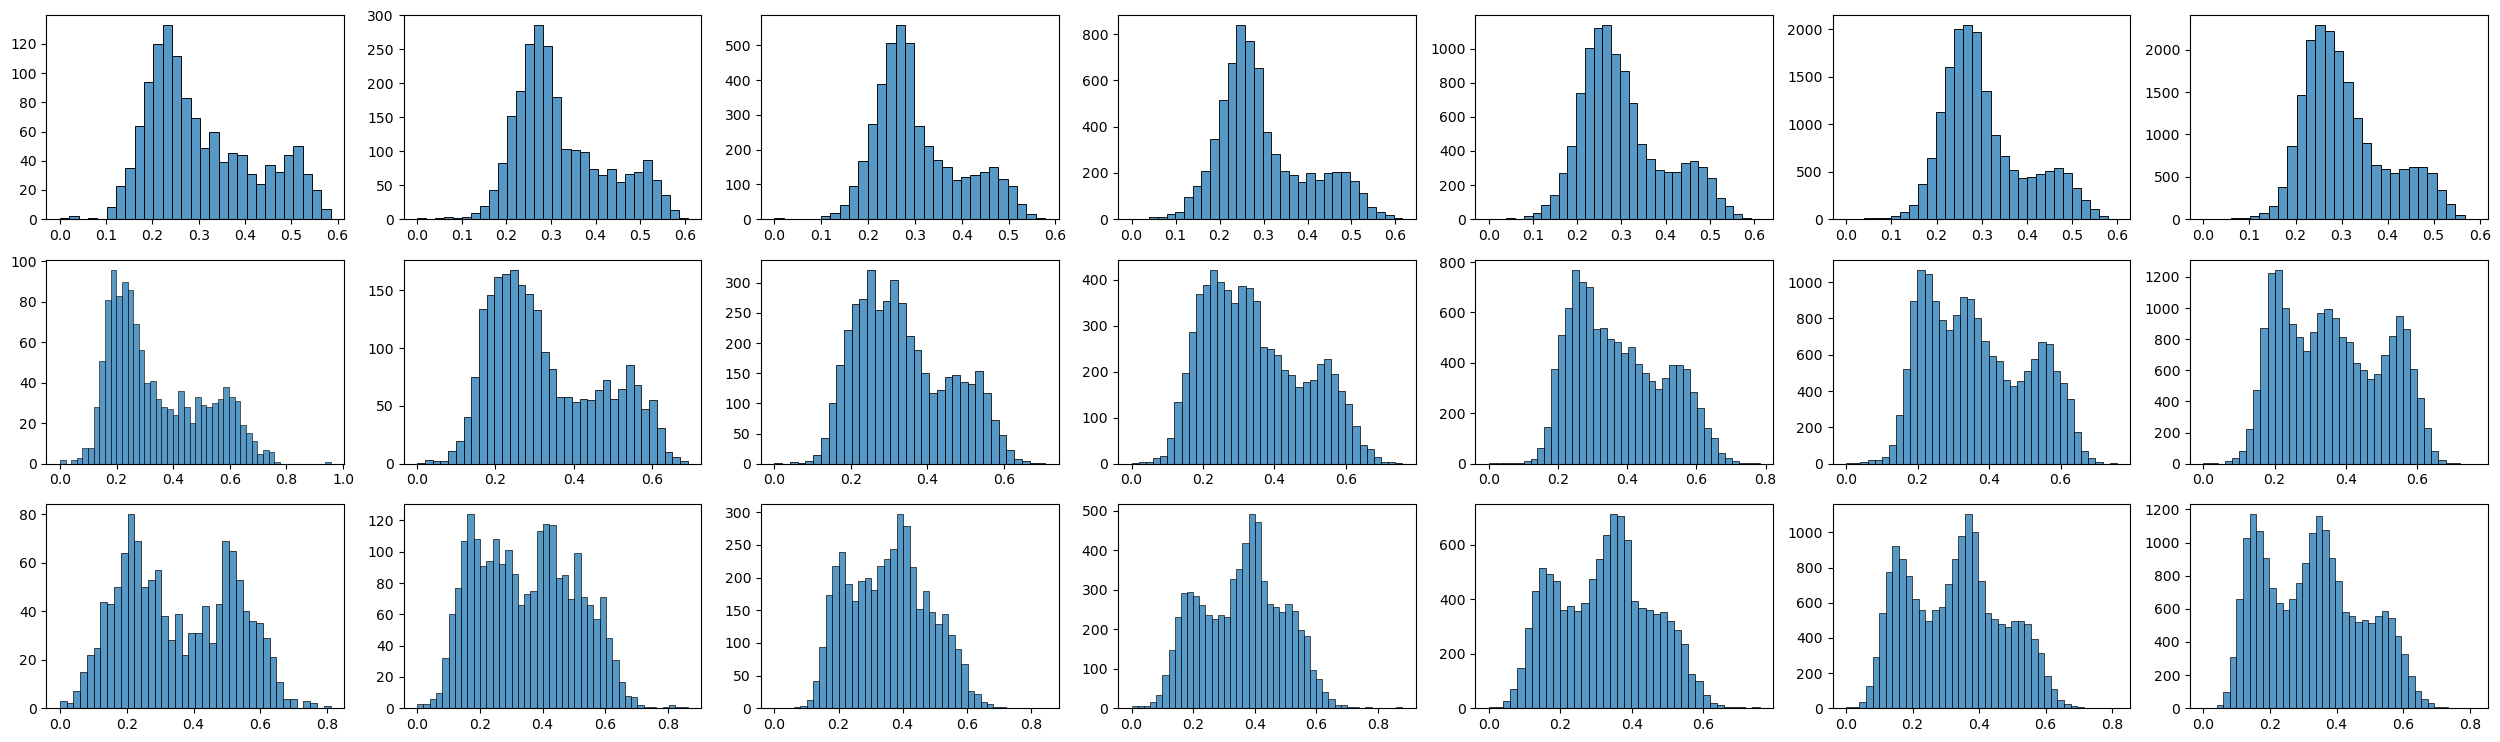

In [80]:
var_list = ['life_cs', 'health_cs', 'physical_cs']

fig4 = plt.figure(figsize=(31.5, 9))
fig4.subplots_adjust(wspace=0.2)

for i, ternary_df in enumerate(ternary_df_list):
    for j, var in enumerate(var_list):
        ax = fig4.add_subplot(3, 7, i+j*7+1)
        hist = sns.histplot(ternary_df, x=var, element='bars', binwidth=0.02)
        hist.set(xlabel=None)
        hist.set(ylabel=None)

In [81]:
fig4.savefig('7_decade_ternary_dist.pdf',  
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# ternary evolution

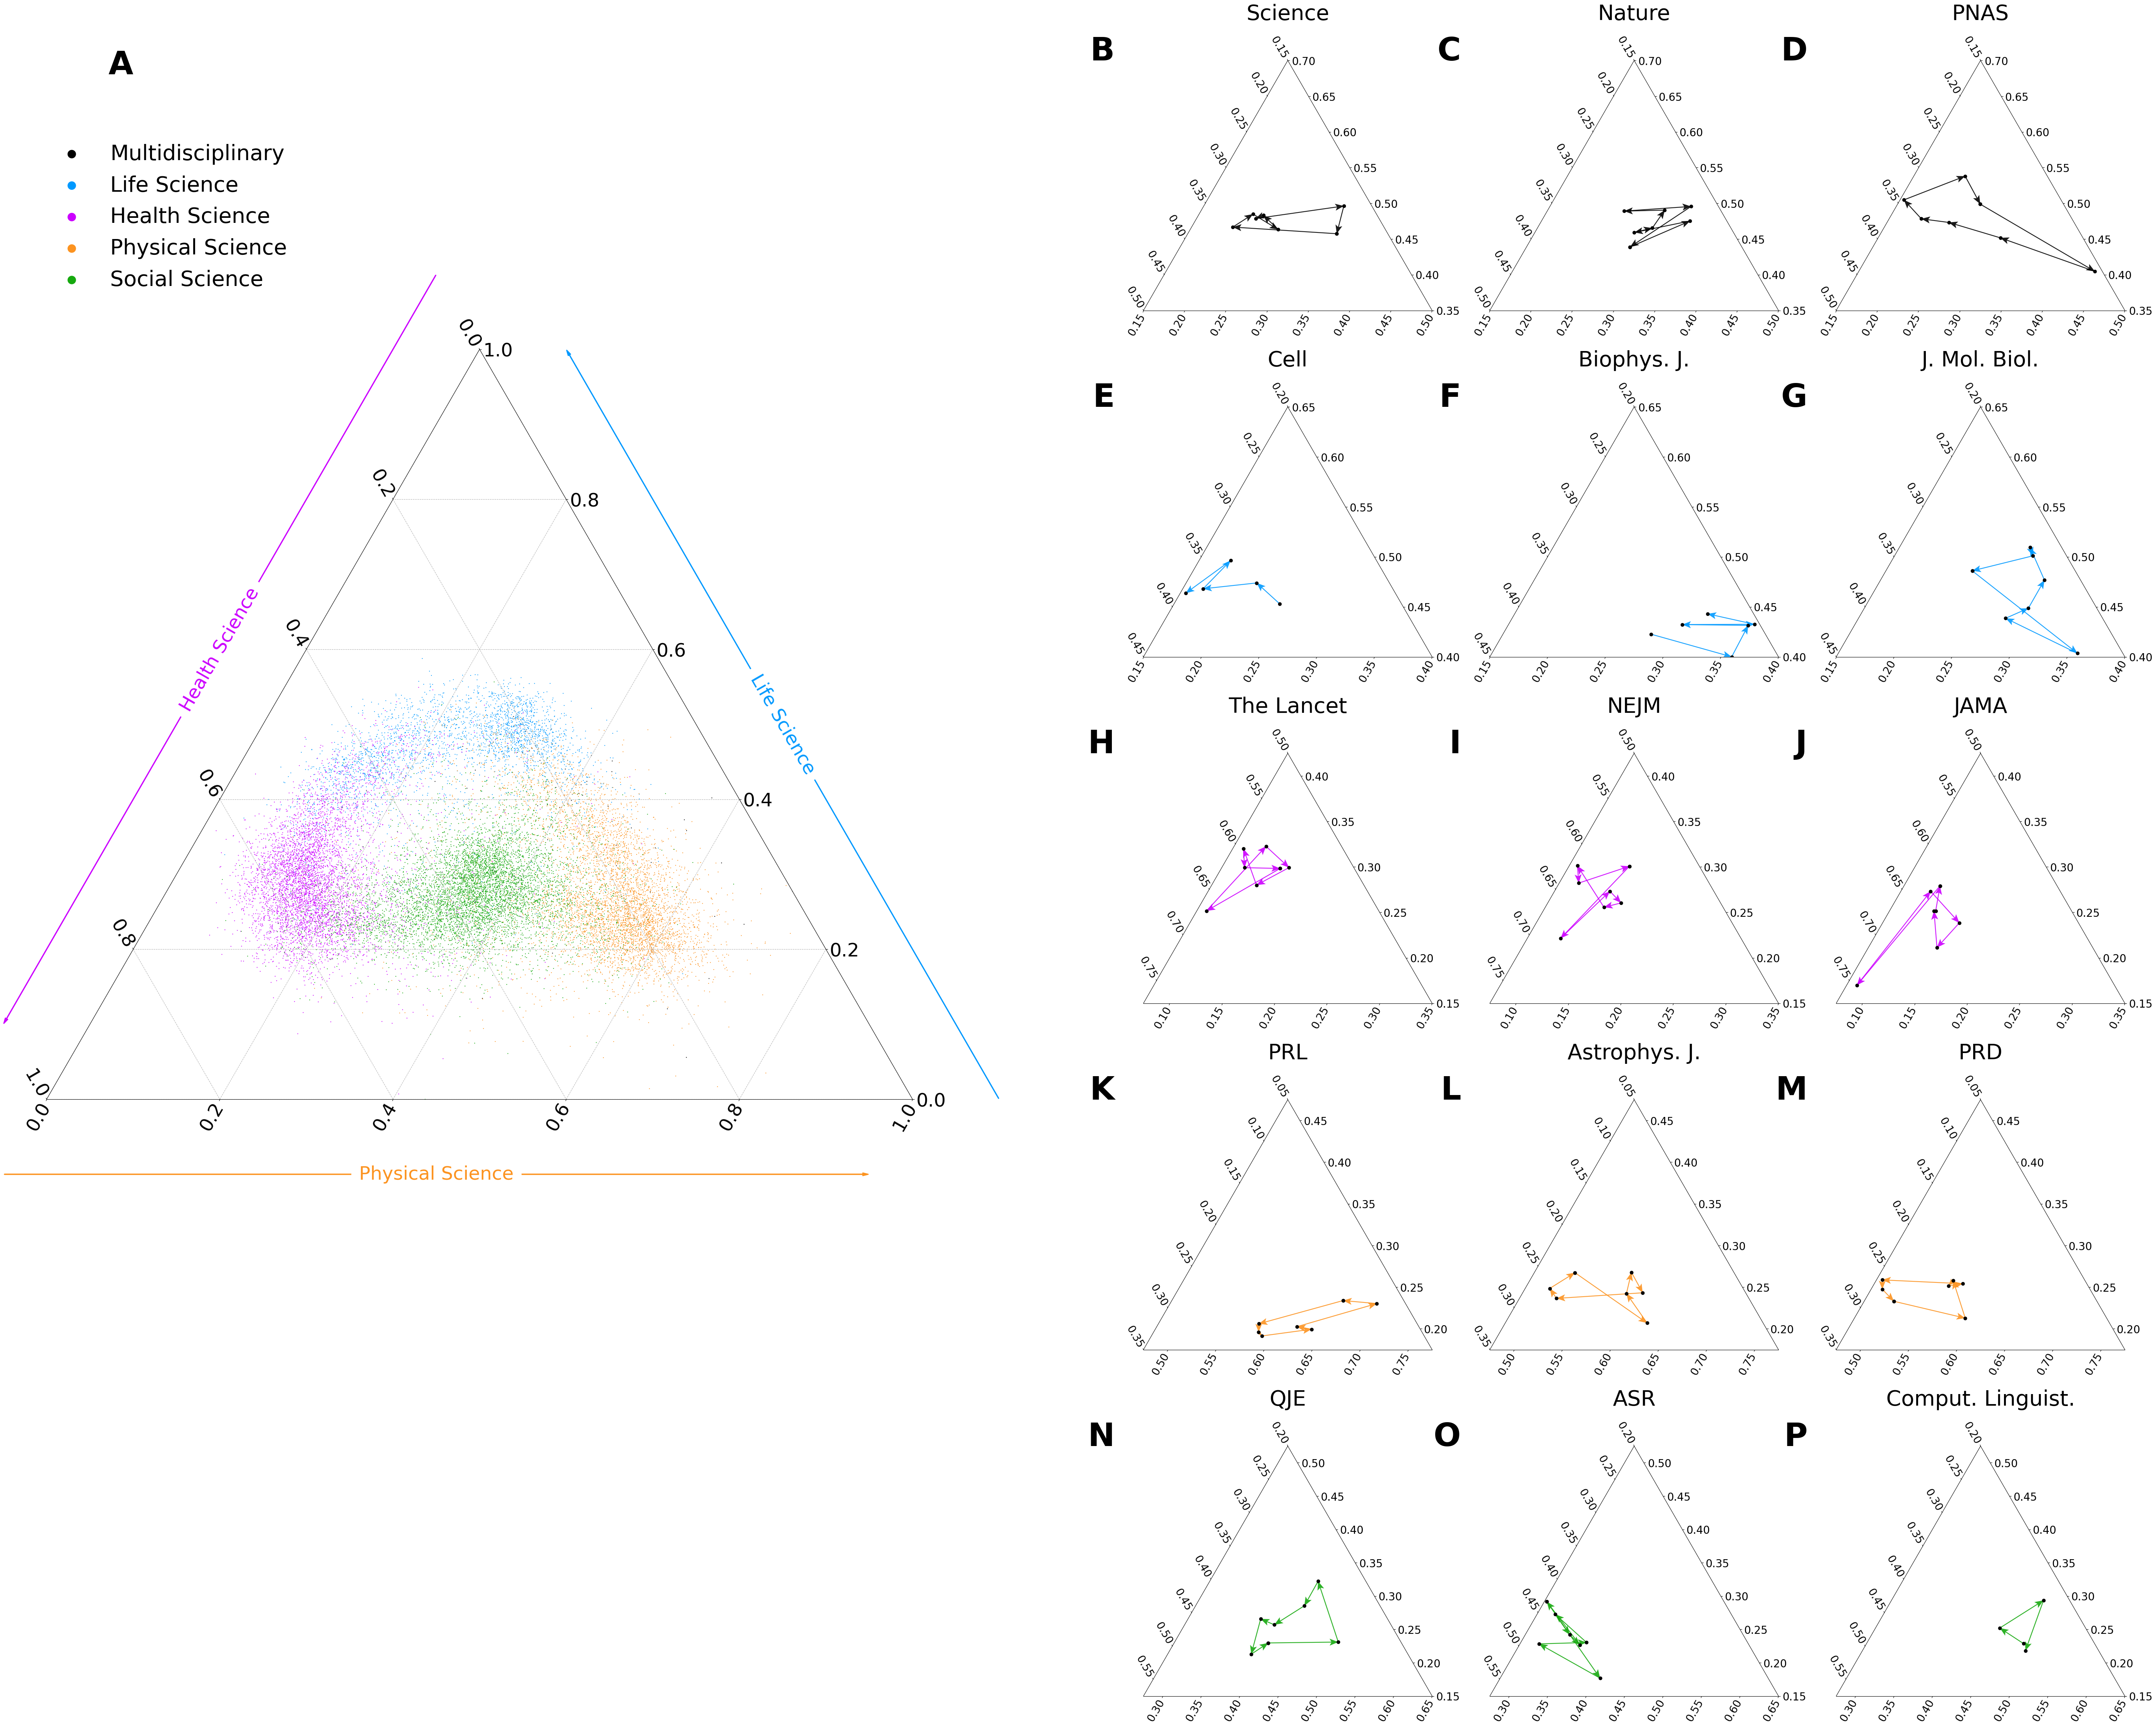

In [5]:
import string
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle, FancyArrowPatch
import mpltern
import numpy as np
import pandas as pd

fig5 = plt.figure(figsize=(15,20))
# fig5.subplots_adjust(left=-0.0)
# ax = fig5.add_subplot(projection='ternary')
ax = fig5.add_axes([-0.7, -0.5, 1.5, 1.5], projection="ternary")
ax.tick_params(labelsize=35)

ta = np.array([ 0.0, -0.1,  1.1])
la = np.array([ 1.1,  0.0, -0.1])
ra = np.array([-0.1,  1.1,  0.0])

tb = np.array([ 1.0, -0.1,  0.1])
lb = np.array([ 0.1,  1.0, -0.1])
rb = np.array([-0.1,  0.1,  1.0])

f = ax.transAxesProjection.transform
arrowstyle = ArrowStyle('simple', head_length=10, head_width=5)

kwargs_arrow = {'transform': ax.transAxes,  # Used with ``ax.transAxesProjection``
                'arrowstyle': arrowstyle,
                'linewidth': 2,
                'clip_on': False,  # To plot arrows outside triangle
                'zorder': -10,  # Very low value not to hide e.g. tick labels.
               }

kwargs_label = {'transform': ax.transTernaryAxes,
                'backgroundcolor': 'w',
                'ha': 'center',
                'va': 'center',
                'rotation_mode': 'anchor',
                'zorder': -9,  # A bit higher on arrows, but still lower than others.
                'fontsize': 35,
}

tarrow = FancyArrowPatch(f(ta), f(tb), ec=life_color, fc=life_color, **kwargs_arrow)
larrow = FancyArrowPatch(f(la), f(lb), ec=health_color, fc=health_color, **kwargs_arrow)
rarrow = FancyArrowPatch(f(ra), f(rb), ec=physical_color, fc=physical_color, **kwargs_arrow)

ax.add_patch(tarrow)
ax.add_patch(larrow)
ax.add_patch(rarrow)

tpos = (ta + tb) * 0.5
lpos = (la + lb) * 0.5
rpos = (ra + rb) * 0.5

ax.text(*tpos, 'Life Science', color=life_color, rotation=-60, **kwargs_label)
ax.text(*lpos, 'Health Science', color=health_color, rotation=60, **kwargs_label)
ax.text(*rpos, 'Physical Science', color=physical_color, rotation=0, **kwargs_label)

ax.grid(linestyle='--')
# ax.taxis.set_major_locator(MultipleLocator(0.05))
# ax.laxis.set_major_locator(MultipleLocator(0.05))
# ax.raxis.set_major_locator(MultipleLocator(0.05))
#------------------------------------------------------------------------#
# 将右边的子图重新排列为 3*5 布局
# 每行三个同领域的期刊，总共五行
small_ax_positions = [
    [1.2, 0.7, 0.5, 0.5], [1.8, 0.7, 0.5, 0.5], [2.4, 0.7, 0.5, 0.5],  # 第一行
    [1.2, 0.25, 0.5, 0.5], [1.8, 0.25, 0.5, 0.5], [2.4, 0.25, 0.5, 0.5],  # 第二行
    [1.2, -0.2, 0.5, 0.5], [1.8, -0.2, 0.5, 0.5], [2.4, -0.2, 0.5, 0.5],  # 第三行
    [1.2, -0.65, 0.5, 0.5], [1.8, -0.65, 0.5, 0.5], [2.4, -0.65, 0.5, 0.5],  # 第四行
    [1.2, -1.1, 0.5, 0.5], [1.8, -1.1, 0.5, 0.5], [2.4, -1.1, 0.5, 0.5]  # 第五行
]

# 更新小子图的排列，并保留之前的 ternary_min 设置
small_ax_list = []

# 添加小子图并设置之前的 ternary_min
for idx, pos in enumerate(small_ax_positions):
    small_ax = fig5.add_axes(pos, projection="ternary")
    small_ax_list.append(small_ax)

    # 根据领域设置 ternary_min
    if idx in [0, 1, 2]:  # 第一行：Multidisciplinary
        small_ax.set_ternary_min(0.35, 0.15, 0.15)
    elif idx in [3, 4, 5]:  # 第二行：Life Science
        small_ax.set_ternary_min(0.4, 0.2, 0.15)
    elif idx in [6, 7, 8]:  # 第三行：Health Science
        small_ax.set_ternary_min(0.15, 0.5, 0.075)
    elif idx in [9, 10, 11]:  # 第四行：Physical Science
        small_ax.set_ternary_min(0.175, 0.05, 0.475)
    elif idx in [12, 13, 14]:  # 第五行：Social Science
        small_ax.set_ternary_min(0.15, 0.2, 0.275)
#------------------------------------------------------------------------#
ternary_df = ternary_df_list[-1]

venue_name_list = ['Science',
                   'Nature',
                   'Proceedings of the National Academy of Sciences of the United States of America', 

                   'Cell',
                   'Biophysical Journal',
                   'Journal of Molecular Biology',
                   
                   'The Lancet',
                   'The New England Journal of Medicine',
                   'JAMA',
                   
                   'Physical Review Letters', 
                   'The Astrophysical Journal',
                   'Physical Review D',

                   'Quarterly Journal of Economics',
                   'American Sociological Review',
                   'Computational Linguistics',
                  ]
color_dict = {'Science': area_color_dict['Multidisciplinary'], 
              'Nature': area_color_dict['Multidisciplinary'],
              'Proceedings of the National Academy of Sciences of the United States of America': area_color_dict['Multidisciplinary'],
              'Multi_AVG': area_color_dict['Multidisciplinary'], 
              
              'Cell': area_color_dict['Life Science'],
              'Biophysical Journal': area_color_dict['Life Science'],
              'Journal of Molecular Biology': area_color_dict['Life Science'],
              'Life_AVG': area_color_dict['Life Science'], 
              
              'The Lancet': area_color_dict['Health Science'], 
              'The New England Journal of Medicine': area_color_dict['Health Science'],
              'JAMA': area_color_dict['Health Science'],
              'Health_AVG': area_color_dict['Health Science'], 

              'Physical Review Letters': area_color_dict['Physical Science'], 
              'The Astrophysical Journal': area_color_dict['Physical Science'],
              'Physical Review D': area_color_dict['Physical Science'],
              'Physical_AVG': area_color_dict['Physical Science'], 

              'Quarterly Journal of Economics': area_color_dict['Social Science'],
              'American Sociological Review': area_color_dict['Social Science'],
              'Computational Linguistics': area_color_dict['Social Science'],
              'Social_AVG': area_color_dict['Social Science'], 
             }

tlr_df = pd.DataFrame(columns=['t_list', 'l_list', 'r_list'],
                     index=venue_name_list)

for venue_name in venue_name_list:
    try:
        tar_df = ternary_df[ternary_df.venue_name==venue_name]
        tlr_df.loc[venue_name] = [[tar_df.life_cs.values[0]], [tar_df.health_cs.values[0]], [tar_df.physical_cs.values[0]]]
    except IndexError:
        tlr_df.loc[venue_name] = [[], [], []]

for ternary_df in ternary_df_list:
    for venue_name in venue_name_list:
        try:
            tar_df = ternary_df[ternary_df.venue_name==venue_name]

            tlr_df.loc[venue_name].t_list.append(tar_df.life_cs.values[0])
            tlr_df.loc[venue_name].l_list.append(tar_df.health_cs.values[0])
            tlr_df.loc[venue_name].r_list.append(tar_df.physical_cs.values[0])

        except IndexError:
            tlr_df.loc[venue_name] = [[], [], []]

        try:
            for small_ax in small_ax_list:
                small_ax.tick_params(labelsize=20)
                if venue_name_list.index(venue_name) == small_ax_list.index(small_ax):
                    alpha=.9
                else:
                    alpha=0.0
                small_ax.quiver(tlr_df.loc[venue_name].t_list[-2], 
                                tlr_df.loc[venue_name].l_list[-2], 
                                tlr_df.loc[venue_name].r_list[-2], 
                                tlr_df.loc[venue_name].t_list[-1] - tlr_df.loc[venue_name].t_list[-2], 
                                tlr_df.loc[venue_name].l_list[-1] - tlr_df.loc[venue_name].l_list[-2], 
                                tlr_df.loc[venue_name].r_list[-1] - tlr_df.loc[venue_name].r_list[-2],
                                angles='xy', scale_units='xy', scale=1, 
                                color=color_dict[venue_name], alpha=alpha, 
                                width=0.0030, headwidth=8, headlength=10, headaxislength=8)
        except IndexError:
            pass
            
for area in ['Multidisciplinary', 'Life Science', 'Health Science', 'Physical Science', 'Social Science']:
    tar_df = ternary_df[ternary_df.area == area]
    t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
    ax.scatter(t, l, r, label=area, marker='.', s=10, color=area_color_dict[area], edgecolors='none', alpha=1)

for venue_name in venue_name_list:
    if venue_name == 'Proceedings of the National Academy of Sciences of the United States of America':
        label_name = 'PNAS'
    elif venue_name == 'The New England Journal of Medicine':
        label_name = 'NEJM'
    elif venue_name == 'Physical Review Letters':
        label_name = 'PRL'
    elif venue_name == 'Physical Review D':
        label_name = 'PRD'
    elif venue_name == 'The Astrophysical Journal':
        label_name = 'Astrophys. J.'
    elif venue_name == 'Quarterly Journal of Economics':
        label_name = 'QJE'
    elif venue_name == 'American Sociological Review':
        label_name = 'ASR'
    elif venue_name == 'Computational Linguistics':
        label_name = 'Comput. Linguist.'
    elif venue_name == 'Biophysical Journal':
        label_name = 'Biophys. J.'
    elif venue_name == 'Journal of Molecular Biology':
        label_name = 'J. Mol. Biol.'
    else: label_name = venue_name

    for small_ax in small_ax_list:
        if venue_name_list.index(venue_name) == small_ax_list.index(small_ax):
            small_ax.set_title(label_name, 
                               y=1.15, fontweight='normal', fontsize=40, loc='center')
            small_ax.scatter(tlr_df.loc[venue_name].t_list, 
                             tlr_df.loc[venue_name].l_list, 
                             tlr_df.loc[venue_name].r_list, 
                             s=35, c='k', alpha=1.0)
        
ax.legend(markerscale=10, fontsize=40, edgecolor='white', bbox_to_anchor=(0.1, 1.1, 0.2, 0.2))

for idx, small_ax in enumerate(small_ax_list):
    # get the Panel Label (A, B, C...) corresponding to the index
    panel_label = string.ascii_uppercase[idx+1]
    
    # add a panel label in the top left corner of each subplot
    small_ax.text(-0.1, 1.1, panel_label, transform=small_ax.transAxes, 
                  fontsize=60, fontweight='bold', va='top', ha='right')
    
ax.text(0.1, 1.4, 'A', transform=ax.transAxes, fontsize=60, fontweight='bold', va='top', ha='right')

plt.show()

In [22]:
fig5.savefig('ternary_evolution.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# Check the Pole vectors 

In [21]:
def cal_pole_vec(start_year, end_year):
    model.load_wv(start_year, end_year, 100, 10)
    VIDs = model.wv.index_to_key
    vectors = model.wv.get_normed_vectors()
    
    vec_df = pd.DataFrame(list(zip(VIDs, vectors)), columns =['VID', 'vector'])
    VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
    vec_df = vec_df.loc[vec_df.VID.isin(VID_labeled['VID'])]
    vec_df['label'] = VID_labeled['label']
    
    vec_df.loc[vec_df.label.isin(['Agricultural and Biological Sciences', 
                                  'Biochemistry, Genetics and Molecular Biology', 
                                  'Immunology and Microbiology', 
                                  'Neuroscience', 
                                  'Pharmacology, Toxicology and Pharmaceutics']), 'area'] = 'Life Science'
    vec_df.loc[vec_df.label.isin(['Medicine', 
                                  'Nursing',
                                  'Veterinary',
                                  'Dentistry',
                                  'Health Professions']), 'area'] = 'Health Science'
    vec_df.loc[vec_df.label.isin(['Chemical Engineering',
                                  'Chemistry',
                                  'Computer Science',
                                  'Earth and Planetary Sciences',
                                  'Energy',
                                  'Engineering',
                                  'Environmental Science',
                                  'Material Science',
                                  'Mathematics',
                                  'Physics and Astronomy']), 'area'] = 'Physical Science'
    vec_df.loc[vec_df.label.isin(['Arts and Humanities',
                                  'Business, Management and Accounting',
                                  'Decision Sciences',
                                  'Economics, Econometrics and Finance',
                                  'Psychology',
                                  'Social Sciences']), 'area'] = 'Social Science'
    vec_df.loc[vec_df.label=='Multidisciplinary', 'area'] = 'Multidisciplinary'
    
    pole_life = vec_df[vec_df.area == 'Life Science'].vector.mean()
    pole_health = vec_df[vec_df.area == 'Health Science'].vector.mean()
    pole_physical = vec_df[vec_df.area == 'Physical Science'].vector.mean()

    return vec_df, [pole_life, pole_health, pole_physical]
    

/tmp/ipykernel_3889807/4279106987.py:4: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax2, ax3, ax4, ax5, ax6, ax7)


2024-01-16 15:03:24 -- start loading word vectors...
2024-01-16 15:03:24 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:03:24 -- start loading VID_labeled...
2024-01-16 15:03:24 -- finish.
2024-01-16 15:03:25 -- start loading word vectors...
2024-01-16 15:03:25 -- word vectors loaded, and its shape is: (3116, 100)
2024-01-16 15:03:25 -- start loading VID_labeled...
2024-01-16 15:03:25 -- finish.
2024-01-16 15:03:25 -- start loading word vectors...
2024-01-16 15:03:25 -- word vectors loaded, and its shape is: (5686, 100)
2024-01-16 15:03:25 -- start loading VID_labeled...
2024-01-16 15:03:25 -- finish.
2024-01-16 15:03:25 -- start loading word vectors...
2024-01-16 15:03:25 -- word vectors loaded, and its shape is: (9337, 100)
2024-01-16 15:03:25 -- start loading VID_labeled...
2024-01-16 15:03:25 -- finish.
2024-01-16 15:03:25 -- start loading word vectors...
2024-01-16 15:03:25 -- word vectors loaded, and its shape is: (15019, 100)
2024-01-16 15:03:25 -- start loa

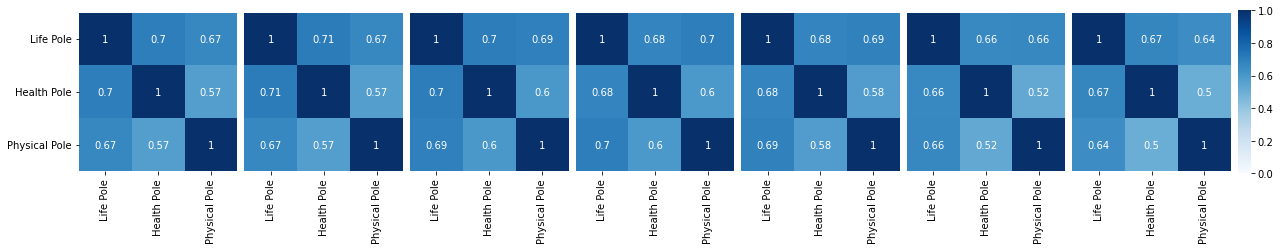

In [102]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, axcb) = plt.subplots(1,8, gridspec_kw={'width_ratios':[1, 1, 1, 1, 1, 1, 1, 0.08],
                                                                              'wspace': 0.05
                                                                             }, figsize=(21,3))
ax1.get_shared_y_axes().join(ax2, ax3, ax4, ax5, ax6, ax7)
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, axcb]

for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    vec_df, pole_list = cal_pole_vec(start_year, end_year)
    cs_df = pd.DataFrame(cosine_similarity(pole_list), 
                         columns=['Life Pole', 'Health Pole', 'Physical Pole'], 
                         index=['Life Pole', 'Health Pole', 'Physical Pole'])
    
    if i == len(model.start_year_list)-7:
        ax = sns.heatmap(cs_df, annot=True, vmin=0, cbar=False, cmap='Blues', square=True, ax = ax_list[i-15])
    else: 
        if i != len(model.start_year_list)-1:
            ax = sns.heatmap(cs_df, annot=True, vmin=0, cbar=False, cmap='Blues', square=True, ax = ax_list[i-15])
            
        if i == len(model.start_year_list)-1:
            ax = sns.heatmap(cs_df, annot=True, vmin=0, cmap='Blues', square=True, ax = ax_list[i-15], cbar_ax=axcb)
            
        ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

In [91]:
def make_random_pole_vec(start_year, end_year):
    model.load_wv(start_year, end_year, 100, 10)
    VIDs = model.wv.index_to_key
    vectors = model.wv.get_normed_vectors()
    
    vec_df = pd.DataFrame(list(zip(VIDs, vectors)), columns =['VID', 'vector'])
    VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
    vec_df = vec_df.loc[vec_df.VID.isin(VID_labeled['VID'])]
    vec_df['label'] = VID_labeled['label']
    
    vec_df.loc[vec_df.label.isin(['Agricultural and Biological Sciences', 
                                  'Biochemistry, Genetics and Molecular Biology', 
                                  'Immunology and Microbiology', 
                                  'Neuroscience', 
                                  'Pharmacology, Toxicology and Pharmaceutics']), 'area'] = 'Life Science'
    vec_df.loc[vec_df.label.isin(['Medicine', 
                                  'Nursing',
                                  'Veterinary',
                                  'Dentistry',
                                  'Health Professions']), 'area'] = 'Health Science'
    vec_df.loc[vec_df.label.isin(['Chemical Engineering',
                                  'Chemistry',
                                  'Computer Science',
                                  'Earth and Planetary Sciences',
                                  'Energy',
                                  'Engineering',
                                  'Environmental Science',
                                  'Material Science',
                                  'Mathematics',
                                  'Physics and Astronomy']), 'area'] = 'Physical Science'
    vec_df.loc[vec_df.label.isin(['Arts and Humanities',
                                  'Business, Management and Accounting',
                                  'Decision Sciences',
                                  'Economics, Econometrics and Finance',
                                  'Psychology',
                                  'Social Sciences']), 'area'] = 'Social Science'
    vec_df.loc[vec_df.label=='Multidisciplinary', 'area'] = 'Multidisciplinary'

    pole_1 = vec_df.sample(len(vec_df[vec_df.area == 'Life Science']), replace=False).vector.mean()
    pole_2 = vec_df.sample(len(vec_df[vec_df.area == 'Health Science']), replace=False).vector.mean()
    pole_3 = vec_df.sample(len(vec_df[vec_df.area == 'Physical Science']), replace=False).vector.mean()

    return vec_df, pole_1, pole_2, pole_3
    

/tmp/ipykernel_3889807/3666065646.py:3: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax2, ax3, ax4, ax5, ax6, ax7)


2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start loading VID_labeled...
2024-01-16 15:01:38 -- finish.
2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start loading VID_labeled...
2024-01-16 15:01:38 -- finish.
2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start loading VID_labeled...
2024-01-16 15:01:38 -- finish.
2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start loading VID_labeled...
2024-01-16 15:01:38 -- finish.
2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start load

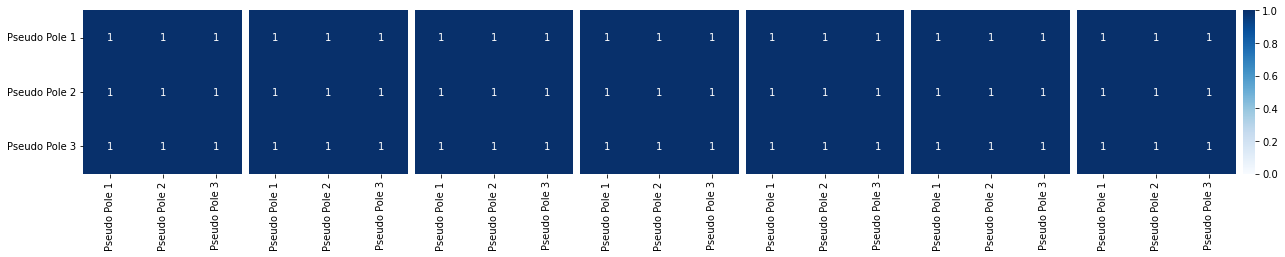

In [101]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, axcb) = plt.subplots(1,8, gridspec_kw={'width_ratios':[1, 1, 1, 1, 1, 1, 1, 0.08],
                                                                              'wspace': 0.05}, figsize=(21,3))
ax1.get_shared_y_axes().join(ax2, ax3, ax4, ax5, ax6, ax7)
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, axcb]

for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    pseudo_pole_df = pd.DataFrame(columns=['pseudo_pole_1', 'pseudo_pole_2', 'pseudo_pole_3'])
    
    for j in range(100):
        vec_df, pole_1, pole_2, pole_3 = make_random_pole_vec(start_year, end_year)
        pseudo_pole_df = pd.concat([pseudo_pole_df, pd.DataFrame({'pseudo_pole_1':[pole_1], 
                                                                  'pseudo_pole_2':[pole_2], 
                                                                  'pseudo_pole_3':[pole_3]})])
    pole_list = [pseudo_pole_df['pseudo_pole_1'].mean(), 
                 pseudo_pole_df['pseudo_pole_2'].mean(), 
                 pseudo_pole_df['pseudo_pole_3'].mean()]
    cs_df = pd.DataFrame(cosine_similarity(pole_list), 
                         columns=['Pseudo Pole 1', 'Pseudo Pole 2', 'Pseudo Pole 3'], 
                         index=['Pseudo Pole 1', 'Pseudo Pole 2', 'Pseudo Pole 3'])
    
    if i == len(model.start_year_list)-7:
        ax = sns.heatmap(cs_df, annot=True, vmin=0, cbar=False, cmap='Blues', ax = ax_list[i-15])
    else: 
        if i != len(model.start_year_list)-1:
            ax = sns.heatmap(cs_df, annot=True, vmin=0, cbar=False, cmap='Blues', ax = ax_list[i-15])
            
        if i == len(model.start_year_list)-1:
            ax = sns.heatmap(cs_df, annot=True, vmin=0, cmap='Blues', ax = ax_list[i-15], cbar_ax=axcb)
            
        ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')